A PINN implementation to solve the following differential equation :

$\frac{d^2 u(x)}{dx^2} + \pi^2 \sin(\pi x) = 0 $

using a Dense Neural Network architecture with :  

1 input layer consisting of 1 node (correspnding to input x) \\
2 hidden layers consisting of 50 nodes each \\
1 output layer consisting of 1 node (corresponding to output u(x)

The $\tanh$ activation function is applied on the nodes in the hidden layer. Optimizer used is ADAM.

PINN is used to learn the solution to the above mentioned differential equation for 2 cases of boundary values :    

(Case 1) $u(x=0) = u(x=1) = 0$

(Case 2) $u(x=0) = 0, u(x=1) = 1 $


Finally, the PINN solution is compared with the analytical solution.
$-------------------------------------------------------------------------------$

Importing tensorflow to create our neural net

In [1]:
import tensorflow as tf
import numpy as np


Building our Dense Neural Network architecture with :

1 input layer consisting of 1 node (correspnding to input x)

2 hidden layers consisting of 50 nodes each

1 output layer consisting of 1 node (corresponding to output u(x)

The  tanh  activation function is applied on the nodes in the hidden layer.

In [2]:
def def_PINN_model():
    PINN = tf.keras.Sequential([
        tf.keras.layers.Dense(50, input_shape=(1,), activation='tanh'),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dense(1)])
    return PINN


Defining the loss function.

Loss function = Residual function + MSE from boundary conditions


If I define the differential equation as $D u(x) = g(x) $, the residual function = $|D u_{estimate}(x) - g(x)|^2$

In [3]:
def loss_fn(PINN, x, g, x_boundary, u_boundary):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u_pred = PINN(x, training=True)  # Get model predictions
        # Compute first derivative
        u_pred_dx = tape.gradient(u_pred, x)
        # Compute second derivative
        u_pred_dx2 = tape.gradient(u_pred_dx, x)

    # The physics-informed loss
    physics_loss = tf.reduce_mean(tf.square(u_pred_dx2 - g))

    # Compute boundary predictions
    u_boundary_pred = PINN(x_boundary)

    # Compute boundary loss (Dirichlet)
    boundary_loss = tf.reduce_mean(tf.square(u_boundary_pred - u_boundary))

    # Total loss
    total_loss = physics_loss + boundary_loss

    return total_loss



Creating the set of collocation points and boundary points. Populating the desired boundary values. Training the PINN on the set of collocation and boundary points with the loss function defined above.

In [4]:
# Prepare the collocation points & boundary values
x = np.linspace(0, 1, 100).reshape(-1, 1).astype('float32') #collocation points
g = -np.pi**2 * np.sin(np.pi * x).astype('float32')
x_boundary = tf.constant([[0], [1]], dtype=tf.float32) #boundary points

#Case 1
#u_boundary = tf.constant([[0], [0]], dtype=tf.float32) #boundary values

#Case 2 :
u_boundary = tf.constant([[0], [1]], dtype=tf.float32) #boundary values




PINN = def_PINN_model()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
for epoch in range(1000):
    with tf.GradientTape() as tape:
        tape.watch(PINN.variables)
        loss = loss_fn(PINN, x, g, x_boundary, u_boundary)
    gradients = tape.gradient(loss, PINN.variables)

    # Check and print gradients for each epoch
    for var, grad in zip(PINN.variables, gradients):
        if grad is not None:
            print(f"Epoch {epoch}, Gradient for {var.name} exists.")
        else:
            print(f"Epoch {epoch}, No gradient for {var.name}")

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    # Apply gradients if they exist
    grad_var_pairs = [(grad, var) for grad, var in zip(gradients, PINN.variables) if grad is not None]
    optimizer.apply_gradients(grad_var_pairs)




Streaming output truncated to the last 5000 lines.
Epoch 168, Gradient for dense/kernel:0 exists.
Epoch 168, Gradient for dense/bias:0 exists.
Epoch 168, Gradient for dense_1/kernel:0 exists.
Epoch 168, Gradient for dense_1/bias:0 exists.
Epoch 168, Gradient for dense_2/kernel:0 exists.
Epoch 168, Gradient for dense_2/bias:0 exists.
Epoch 169, Gradient for dense/kernel:0 exists.
Epoch 169, Gradient for dense/bias:0 exists.
Epoch 169, Gradient for dense_1/kernel:0 exists.
Epoch 169, Gradient for dense_1/bias:0 exists.
Epoch 169, Gradient for dense_2/kernel:0 exists.
Epoch 169, Gradient for dense_2/bias:0 exists.
Epoch 170, Gradient for dense/kernel:0 exists.
Epoch 170, Gradient for dense/bias:0 exists.
Epoch 170, Gradient for dense_1/kernel:0 exists.
Epoch 170, Gradient for dense_1/bias:0 exists.
Epoch 170, Gradient for dense_2/kernel:0 exists.
Epoch 170, Gradient for dense_2/bias:0 exists.
Epoch 171, Gradient for dense/kernel:0 exists.
Epoch 171, Gradient for dense/bias:0 exists.
Epoch

PINN is now trained. Generating a set of points in the solution domain $x_{test}$ to test it against the analytical solution.

In [5]:
# Generate predictions
x_test = np.linspace(0, 1, 70).reshape(-1, 1).astype('float32')
u_pred = PINN(x_test).numpy()


Case 1 : analytical solution is $\sin(\pi x)$

Case 2 : analytical solution is $\sin(\pi x) + x$

In [8]:
#Case 1
#u_analytical = np.sin(np.pi * x_test)

#Case 2
u_analytical = np.sin(np.pi * x_test) + x_test


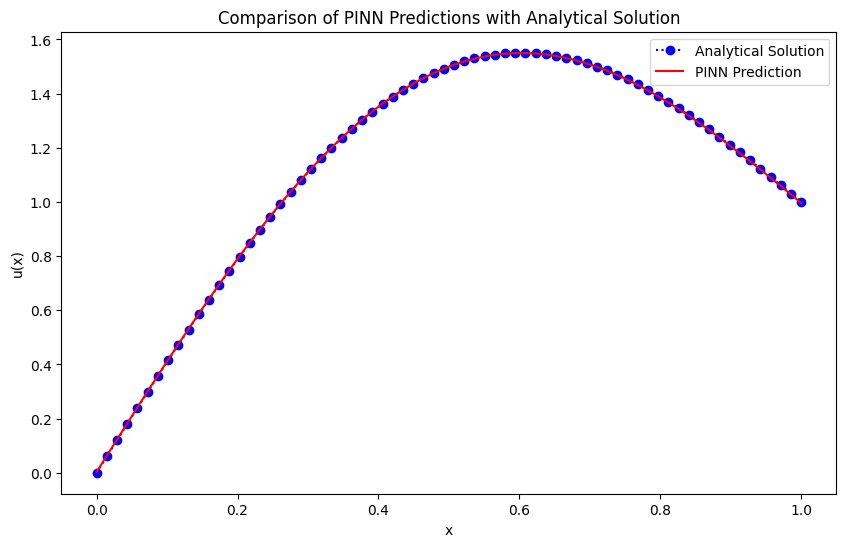

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_test, u_analytical, label='Analytical Solution', color='blue', linestyle=':',marker = 'o')
plt.plot(x_test, u_pred, label='PINN Prediction', color='red', linestyle='-')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Comparison of PINN Predictions with Analytical Solution')
plt.show()
